<a href="https://colab.research.google.com/github/amyush/FrequencyDomain_Watermarking/blob/attacksOnWatermarkedImages/watermarking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setting up the environment**

In [1]:
!git clone https://github.com/amyush/FrequencyDomain_Watermarking.git

Cloning into 'FrequencyDomain_Watermarking'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 71 (delta 35), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (71/71), done.


In [2]:
import numpy as np
import cv2
import math
import pywt
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from PIL import Image as im
import math
from scipy.fftpack import dct
from scipy.fftpack import idct
from google.colab.patches import cv2_imshow

# **Custom Functions**

In [29]:
def setParams():
    global alpha 
    alpha = 0.02
    global betaFactor
    betaFactor = 1
    global imgPath
    imgPath = "FrequencyDomain_Watermarking/"
    global factor
    factor = 8

def stringToBinary(a):
  l=[]
  res = ''.join(format(ord(i), '08b') for i in a)
  return res

def calculatePSNR(original, compressed):
    mse = np.mean((original - compressed) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                    # Therefore PSNR have no importance.
        return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

def apply_dct(image_array):
    # size = (int)(math.sqrt(image_array.size))
    size = len(image_array[0])
    all_subdct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subpixels = image_array[i:i+8, j:j+8]
            subdct = dct(dct(subpixels.T, norm="ortho").T, norm="ortho")
            all_subdct[i:i+8, j:j+8] = subdct

    return all_subdct

def inverse_dct(all_subdct):
    size = len(all_subdct[0])
    all_subidct = np.empty((size, size))
    for i in range (0, size, 8):
        for j in range (0, size, 8):
            subidct = idct(idct(all_subdct[i:i+8, j:j+8].T, norm="ortho").T, norm="ortho")
            all_subidct[i:i+8, j:j+8] = subidct
    return all_subidct


# **Steganography**

## **Hiding the data**

In [4]:
def encodingImage(imageName, key, hiddenImageName):
    setParams();
    binKey = stringToBinary(key)
    lenBinKey = len(binKey)

    # Reading the cover image
    originalImage = cv2.imread(imgPath + imageName)

    sizeOrig = 512
    originalImage = cv2.resize(originalImage, (sizeOrig, sizeOrig))

    # Reading the watermark image
    waterMarkLogo = cv2.imread(imgPath + hiddenImageName)
    sizeWatermark = 64
    waterMarkLogo = cv2.resize(waterMarkLogo, (sizeWatermark, sizeWatermark))
    
    waterMarkArray = np.array(waterMarkLogo,dtype=float)

    flatWaterMarkArray = np.zeros(shape = (sizeWatermark,sizeWatermark,3))
    flatWaterMarkArray[:,:,0] = apply_dct(waterMarkArray[:,:,0])
    flatWaterMarkArray[:,:,1] = apply_dct(waterMarkArray[:,:,1])
    flatWaterMarkArray[:,:,2] = apply_dct(waterMarkArray[:,:,2])
    
    waterMarkedImage = np.zeros((sizeOrig,sizeOrig,3))

    for dim in range(0,3,1):
        inputArray = np.array(originalImage[:,:,dim], dtype=float)
        flatWaterMark = (flatWaterMarkArray[:,:,dim]/255).ravel()
        index = -1
        count = 0
        beta = betaFactor

        for i in range(0, sizeOrig, 8):
            for j in range(0, sizeOrig, 8):
                index += 1
                if((int)(binKey[index%lenBinKey]) == 1):
                    beta *= -1
                inputArray[i:i+8,j:j+8]=dct(dct(inputArray[i:i+8,j:j+8].T, norm="ortho").T, norm="ortho")
                inputArray[i+1][j+1] += alpha * beta * flatWaterMark[count]
                inputArray[i:i+8,j:j+8]=idct(idct(inputArray[i:i+8,j:j+8].T, norm="ortho").T, norm="ortho")
                count += 1

        waterMarkedImage[:,:,dim] = inputArray

    
    res = cv2.imwrite('waterMarkedImage.jpg', waterMarkedImage)
    return originalImage, waterMarkedImage, waterMarkLogo, sizeWatermark


## **Extracting the watermark image**

In [5]:
def extractImage(imageName, waterMarkedImage, key):
    setParams();
    binKey = stringToBinary(key)
    lenBinKey = len(binKey)

    sizeOrig = waterMarkedImage.shape[0]
    size = sizeOrig // 8
    originalImage = cv2.imread(imgPath + imageName)
    originalImage = cv2.resize(originalImage, (sizeOrig, sizeOrig))
    logo = np.zeros(shape = (size,size,3))

    for dim in range(0,3,1):
        inputArray = np.array(originalImage[:,:,dim], dtype=float)
        test_1=waterMarkedImage[:,:,dim]

        ext_wm=[]
        k=0
        z=0
        beta = betaFactor
        index = -1
        
        for i in range(0,sizeOrig,8):
            for j in range(0,sizeOrig,8):
                index += 1
                if((int)(binKey[index%lenBinKey]) == 1):
                    beta *= -1

                subOrignal = dct(dct(inputArray[i:i+8,j:j+8].T, norm="ortho").T, norm="ortho")
                subWaterMarked = dct(dct(test_1[i:i+8,j:j+8].T, norm="ortho").T, norm="ortho")

                val= (beta * (subWaterMarked[1][1] - subOrignal[1][1])) / alpha

                ext_wm.append(val)
        ext_wm = np.array(ext_wm,dtype=float).reshape((size,size))
        logo[:,:,dim] = inverse_dct(ext_wm)

    logo = logo * 255
    logo = logo.astype(np.uint8)

    cv2_imshow(logo)
    return logo

# **Attacks**

In [25]:
def attackGauss(image):
    row,col,ch= image.shape
    mean = 0
    var = 0.01
    sigma = var**0.5

    gauss = np.random.normal(mean,sigma,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    noisyImage = image + gauss
    return noisyImage

def attackSNP(image):
    row,col,ch = image.shape
    s_vs_p = 0.5
    amount = 0.01
    sNpImage = np.copy(image)
    
    # Salt mode
    num_salt = np.ceil(amount * image.size * s_vs_p)
    coords = [np.random.randint(0, i - 1, int(num_salt))
            for i in image.shape]
    sNpImage[coords] = 1

    # Pepper mode
    num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
    coords = [np.random.randint(0, i - 1, int(num_pepper))
            for i in image.shape]
    sNpImage[coords] = 0
    return sNpImage


def attackPoisson(image):
    vals = len(np.unique(image))
    vals = 2 ** np.ceil(np.log2(vals))
    noisy = np.random.poisson(image * vals) / float(vals)
    return noisy
    
def attackSpeckle(image):
    row,col,ch = image.shape
    gauss = np.random.randn(row,col,ch)
    gauss = gauss.reshape(row,col,ch)        
    noisy = image + image * gauss
    return noisy

def attackRotate90(image):
    angle = 90
    scale = 1.0
    w = image.shape[1]
    h = image.shape[0]
    rangle = np.deg2rad(angle)  # angle in radians
    nw = (abs(np.sin(rangle) * h) + abs(np.cos(rangle) * w)) * scale
    nh = (abs(np.cos(rangle) * h) + abs(np.sin(rangle) * w)) * scale
    rot_mat = cv2.getRotationMatrix2D((nw * 0.5, nh * 0.5), angle, scale)
    rot_move = np.dot(rot_mat, np.array(
        [(nw - w) * 0.5, (nh - h) * 0.5, 0]))
    rot_mat[0, 2] += rot_move[0]
    rot_mat[1, 2] += rot_move[1]
    noisy=cv2.warpAffine(image, rot_mat, (int(math.ceil(nw)), int(math.ceil(nh))), flags=cv2.INTER_LANCZOS4)
    return noisy

def averageFilter(images):
    m = images.shape[0]
    n = images.shape[1]
    filter = np.ones([3,3], dtype=int)
    filter = filter/9
    avgImg = np.zeros((m,n,3))

    for dim in range(0,3):
        image = images[:,:,dim]
        for i in range(1, m-1):
            for j in range(1, n-1):
                temp = (image[i-1, j-1]*filter[0, 0])+(image[i-1, j]*filter[0, 1])+(image[i-1, j + 1]*filter[0, 2])+(image[i, j-1]*filter[1, 0])+ (image[i, j]*filter[1, 1])+(image[i, j + 1]*filter[1, 2])+(image[i + 1, j-1]*filter[2, 0])+(image[i + 1, j]*filter[2, 1])+(image[i + 1, j + 1]*filter[2, 2])         
                avgImg[i,j,dim] = temp
    cv2.imwrite('average.png', avgImg)
    return avgImg

def medianFilter(image):
    m = image.shape[0]
    n = image.shape[0]
    img_new1 = np.zeros([m, n, 3])

    for dim in range(0,3):
        for i in range(1, m-1):
            for j in range(1, n-1):
                temp = [image[i-1, j-1, dim], image[i-1, j, dim], image[i-1, j + 1, dim], image[i, j-1, dim], image[i, j, dim],
                    image[i, j + 1, dim], image[i + 1, j-1, dim], image[i + 1, j, dim], image[i + 1, j + 1, dim]]
                temp = sorted(temp)
                img_new1[i, j, dim]= temp[4]

    img_new1 = img_new1.astype(np.uint8)
    cv2.imwrite('median.png', img_new1)
    return img_new1


# **Results**

In [7]:
# coverFileName = input("Enter the cover filename: (eg- cover.jpg or lena.png)")
# key = input("Enter the key:")
# waterMarkImageName = input("Enter the name of the image to be hidden: (eg- iitbbs_logo.jpeg or logo.png)")

coverFileName = 'lena.png'
key = 'Appa'
# hiddenImageName = 'iitbbs_logo.jpeg'
hiddenImageName = 'logo.png'

originalImage, waterMarkedImage, waterMarkLogo, size = encodingImage(coverFileName, key, hiddenImageName)
psnr = calculatePSNR(waterMarkedImage, originalImage)
print('PSNR value = {}'.format(psnr))

# cv2_imshow(originalImage)
# cv2_imshow(waterMarkedImage)

PSNR value = 102.87995799138363


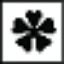

[[0.99999535]]


In [8]:
# Extracting the watermark logo from encoded image
extractedLogo = extractImage(coverFileName, waterMarkedImage, 'Appa')
nc_res = cv2.matchTemplate(waterMarkLogo, extractedLogo,cv2.TM_CCORR_NORMED)
print(nc_res)

In [ ]:













# print("Gauss Attack Results :")
# cv2_imshow(gaussNoiseImage)    
# print("s&p Attack Results :")
# cv2_imshow(sNpNoiseImage)


## **Gaussian Attack**

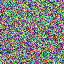

[[0.7303302]]


In [10]:
gaussNoiseImage = attackGauss(waterMarkedImage)
gaussNoisePSNR = calculatePSNR(originalImage, gaussNoiseImage)
print("PSNR value after gaussian attack is: ", gaussNoisePSNR)

extractedLogo = extractImage(coverFileName, gaussNoiseImage, 'Appa')
nc_res = cv2.matchTemplate(waterMarkLogo, extractedLogo,cv2.TM_CCORR_NORMED)
print(nc_res)

## **Average Attack**

In [ ]:
averageAttackImage = averageFilter(waterMarkedImage)
averageAttackPSNR = calculatePSNR(originalImage, averageAttackImage)
print("PSNR value after average attack is: ", averageAttackPSNR)

extractedLogo = extractImage(coverFileName, averageAttackImage, 'Appa')
nc_res = cv2.matchTemplate(waterMarkLogo, extractedLogo,cv2.TM_CCORR_NORMED)
print(nc_res)

## **Speckle** **Attack**

In [ ]:
speckleNoiseImage = attackSpeckle(waterMarkedImage)
specklePSNR = calculatePSNR(originalImage, speckleNoiseImage)
print("PSNR value after speckle attack is: ", specklePSNR)
extractedLogo = extractImage(coverFileName, speckleNoiseImage, 'Appa')
nc_res = cv2.matchTemplate(waterMarkLogo, extractedLogo,cv2.TM_CCORR_NORMED)
print(nc_res)

## **Poisson Attack**

In [ ]:
poissonNoiseImage = attackPoisson(waterMarkedImage)
poissonPSNR = calculatePSNR(waterMarkedImage, poissonNoiseImage)
print("PSNR value after poisson attack is: ", poissonPSNR)
extractedLogo = extractImage(coverFileName, poissonNoiseImage, 'Appa')
nc_res = cv2.matchTemplate(waterMarkLogo, extractedLogo,cv2.TM_CCORR_NORMED)
print(nc_res)

## **Median** **Attack**

In [ ]:
medianAttackImage = medianFilter(waterMarkedImage)
medianAttackPSNR = calculatePSNR(originalImage, medianAttackImage)
print("PSNR value after median attack is: ", medianAttackPSNR)
extractedLogo = extractImage(coverFileName, medianAttackImage, 'Appa')
nc_res = cv2.matchTemplate(waterMarkLogo, extractedLogo,cv2.TM_CCORR_NORMED)
print(nc_res)

## **SNP Attack**

In [ ]:
sNpNoiseImage = attackSNP(waterMarkedImage)
sNpNoisePSNR = calculatePSNR(originalImage, sNpNoiseImage)
print("PSNR value after salt-N-pepper attack is: ", sNpNoisePSNR)

extractedLogo = extractImage(coverFileName, sNpNoiseImage, 'Appa')
nc_res = cv2.matchTemplate(waterMarkLogo, extractedLogo,cv2.TM_CCORR_NORMED)
print(nc_res)


## **Geometric attack - rotate by 90**

In [ ]:
rotate90Image = attackRotate90(waterMarkedImage)
rotate90PSNR = calculatePSNR(originalImage, rotate90Image)
print("PSNR value after rotate90 attack is: ", rotate90PSNR)
extractedLogo = extractImage(coverFileName, rotate90Image, 'Appa')
nc_res = cv2.matchTemplate(waterMarkLogo, extractedLogo,cv2.TM_CCORR_NORMED)
print(nc_res)